In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.stats import mad_std
from matplotlib.colors import LogNorm
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1 final_sum
       pix       pix                                           
--- --------- --------- -------------- -------------- ---------
  1 25.911138 7.2095123      31.469223      6.0187802 28.049461
  2 341.52319 72.262685      23.443185      7.8957739  18.95695
  3 157.53957 91.090512      25.390963      8.1548079 20.757549
  4 141.57204 94.060314      19.162592      9.3594067 13.844748
  5 14.664047 188.87988      107.71095      9.6699504 102.21666
  6 68.634487 226.02955      380.84802      13.426339 373.21942
  7 33.183087 234.55881      20.249117      14.755406 11.865363
  8 180.23829 307.37791      23.359754      7.9077346 18.866723


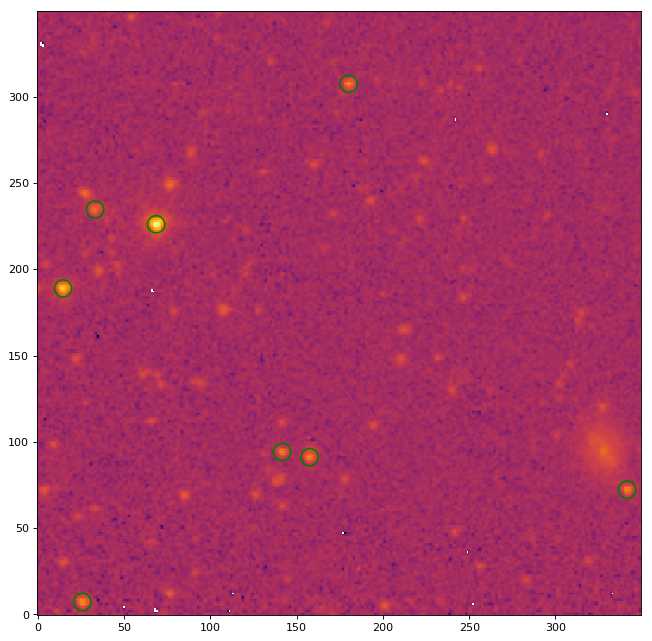

In [14]:
#input an epoch number, file will be extracted from my spitzer images folder
#opens the data part of the fits file and selects a large section in more or less the middle (to avoid nans)
#(and I know my star is in there)

epoch = '16'
filename = '/u/m/amw58/dos/MPHYS_PROJECT/spitzer_images/43/43__e1_xc'+epoch+'/43__e1_xc'+epoch+'_3p6um.fits'
RR43 = fits.open(filename)
image_data = RR43[0].data
region = image_data[100:450,100:450]

#define bkg_sigma, the median background, as well as the width star_w which I use for both the detection of stars
#and the aperture width

bkg_sigma = mad_std(region,ignore_nan=True)
star_w = 5.

#finds some stars. Threshold is quite high but it still finds a fair few

daofind = DAOStarFinder(fwhm=star_w,threshold=70.*bkg_sigma)
sources = daofind(region)
for col in sources.colnames:
    sources[col].info.format='%.8g'
    
#the aperture photometry bit. Defines an aperture with radius (not width, oops, I'll sort that) of star_w, and
#an annulus around the star to pick up background noise. 
    
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=star_w)
annuli = CircularAnnulus(positions,r_in=10.,r_out=12.)
totals = [apertures,annuli]
phot_table = aperture_photometry(region, totals)
for col in phot_table.colnames:
    phot_table[col].info.format='%.8g'

#plots it so I know what's going on (plus it's pretty, inferno is a great colourmap)
    
plt.figure(figsize=(10,10),dpi=80)
plt.imshow(region,cmap='inferno',origin='left',aspect='equal',norm=LogNorm())
apertures.plot(color='green',lw=1.5,alpha=1)

#takes away the background from phot_table (the list of fluxes)

bkg_mean = phot_table['aperture_sum_1']/annuli.area()
bkg_sum = bkg_mean*apertures.area()
final_sum = phot_table['aperture_sum_0']-bkg_sum
phot_table['final_sum']=final_sum

#prints the final phot_table. I know from the picture that the RRL is at about 180, 308 in this data, so I
#manually read off the final_sum from here and put it into the light curve

print phot_table

In [4]:
print np.mean(bkg_mean)
print bkg_sigma

0.06980047409760143
0.014885210408382532


Text(0,0.5,'Measured fluxes (???)')

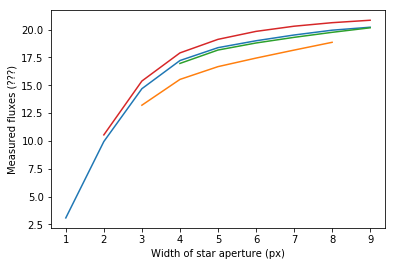

In [6]:
#Growth curve!! (incomplete)

star_widths = [1,2,3,4,5,6,7,8,9]
fluxes_alle = [3.083,9.943,14.687,17.216,18.373,18.993,19.51,19.943,20.21]
fluxes_e1 = [13.206,15.521,16.669,17.438,18.155,18.854]
fluxes_e7 = [16.957,18.16,18.793,19.3,19.751,20.158]
fluxes_e10 = [10.54,15.377,17.902,19.12,19.836,20.3,20.617,20.836]

plt.plot(star_widths,fluxes_alle)
plt.plot(star_widths[2:8],fluxes_e1)
plt.plot(star_widths[3:9],fluxes_e7)
plt.plot(star_widths[1:9],fluxes_e10)
plt.xlabel('Width of star aperture (px)')
plt.ylabel('Measured fluxes (???)')

In [7]:
fluxes5px = []
epochs = np.linspace(1,12,12)

In [8]:
epoch = '01'
filename = '/u/m/amw58/dos/MPHYS_PROJECT/spitzer_images/43/43__e1_xc'+epoch+'/43__e1_xc'+epoch+'_3p6um.fits'
RR43 = fits.open(filename)
image_header = RR43[0].header
print image_header['FLUXCONV']

0.1253


Text(0,0.5,'Flux (some units)')

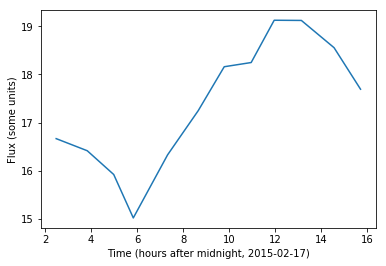

In [12]:
#data from the main 12 epochs - time in hours after midnight

times = [2.48,3.83,4.98,5.83,7.32,8.65,9.78,10.95,11.95,13.13,14.55,15.7]
fluxes5px = [16.669,16.418,15.925,15.025,16.333,17.249,18.16,18.247,19.124,19.12,18.555,17.694]

plt.plot(times,fluxes5px)
plt.xlabel('Time (hours after midnight, 2015-02-17)')
plt.ylabel('Flux (some units)')


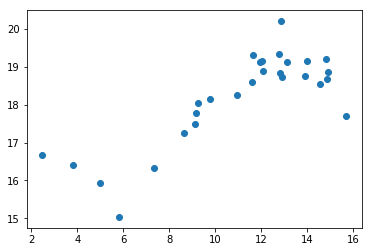

In [10]:
#incorporating data from the extra 16 epochs

times = [2.48,3.83,4.98,5.83,7.32,8.65,9.13,9.18,9.25,9.78,10.95,11.58,11.65,11.95,12.02,12.08,12.78,12.85,12.9,13.13,12.83,13.9,13.97,14.55,14.8,14.85,14.92,15.7]
fluxes5px = [16.669,16.418,15.925,15.025,16.333,17.249,17.485,17.77,18.043,18.16,18.247,18.592,19.3,19.124,19.16,18.88,19.337,20.212,18.736,19.12,18.845,18.764,19.157,18.555,19.211,18.685,18.867,17.694]

plt.scatter(times,fluxes5px,)